# deep learning 手把手

## 匯入相關套件

In [1]:
import time
import os
import numpy as np
import tensorflow as tf
from tqdm import tqdm_notebook   ##顯示進度條
import matplotlib.pyplot as plt
import pandas as pd


## 使用GPU
若有多個GPU，預設是全拿，可以指定GPU

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
tf.test.is_gpu_available()    ## 有GPU可用嗎
# tf.test.gpu_device_name()     ## 顯示GPU的名稱

False

## 讀資料


In [10]:
df_train = pd.read_csv('./data/train.csv')
df_train = df_train.drop(labels=['Id'],axis=1)

# 轉成np array

- np.array()
- dataframe.values

In [11]:
df_train.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

In [12]:
X_train = df_train.drop(labels=['Cover_Type'],axis=1).values
y_train = df_train['Cover_Type'].values

# 1. preprocessing

## normalization (用min-max scaler轉成0-1之間)
- 取小值(0~1之間)、同值性(都壓縮到同個range)  --->  容易收斂  <span style='color:red'>by keras作者</span>
- 目的要讓每個特徵所對應的weight都縮放到同一個標準，min_max是讓weight都變成0~1之間

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler()
X_train = X_train.astype(np.float32)
X_train = scaler.fit_transform(X_train)

## one-hot encoding

In [15]:
num_classes = len(np.unique(y_train))
## shift 1格 , 讓範圍變到0~6
y_train = y_train - 1
y_train = np.eye(num_classes)[y_train]

## train val split

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
train_x , val_x , train_y , val_y = train_test_split(X_train,y_train , test_size=.2 , random_state=42 )



# 2. build model

In [18]:
## parameters
epochs = 10
batch_size = 32 
lr = 1e-4
every_print = 5


In [19]:
tf.reset_default_graph()

with tf.name_scope('input'):
    x_input = tf.placeholder(dtype=tf.float32,shape=(None,)+train_x.shape[1:],name = 'x_input')
    y_out = tf.placeholder(dtype=tf.float32 , shape=(None,)+train_y.shape[1:],name = 'y_out')
    
    

In [20]:
def dense_layer(input_tensor , units ):
    
    x = tf.layers.dense(input_tensor,units=units,
                        activation=tf.nn.relu , 
                        kernel_initializer=tf.truncated_normal_initializer())
    return x



In [14]:
with tf.variable_scope('hidden') as scope:
    x_1 = dense_layer(x_input,512)
    x_2 = dense_layer(x_1,256)
    x_3 = dense_layer(x_2,128)

with tf.variable_scope('output_layer') as scope:
    output = tf.layers.dense(x_3,num_classes,name='output')



Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.



## build loss function

In [15]:
with tf.name_scope('loss') as scope:
    avg_loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits_v2(
            labels=y_out ,logits=output,name='loss'))
   
    
    

## build optimizer

In [16]:
with tf.name_scope('opt') as scope:
    train_step = tf.train.AdamOptimizer(learning_rate=lr).minimize(avg_loss)
    
    

## compute accuracy

In [17]:
with tf.name_scope('acc') as scope:
    predict_class = tf.argmax(output,axis=1)
    y_class = tf.argmax(y_out,axis=1)
    acc = tf.reduce_mean(tf.cast(tf.equal(predict_class,y_class),dtype=tf.float32))
    
    
    

# 3.train model

In [18]:
from sklearn.utils import shuffle

sess = tf.Session()
sess.run(tf.global_variables_initializer())



train_loss_epoch = []
train_acc_epoch = []

for i in tqdm_notebook(range(epochs)):
    start_time = time.time()
    print(f"\nepoch: {i+1}/{epochs} \n")
    
    train_batch_loss = []
    train_batch_acc =[]

    
    batch_num = int(np.ceil(len(train_x)/batch_size))
    split_step = batch_num // every_print
    train_x , train_y = shuffle(train_x , train_y)
    
    for j in range(batch_num):
#         batch_start = time.time()
        
        x_batch = train_x[j*batch_size : min((j+1)*batch_size , len(train_x)) ]
        y_batch = train_y[j*batch_size : min((j+1)*batch_size , len(train_y)) ]
        
        _ , train_loss , train_acc =sess.run([train_step , avg_loss , acc],
                                            feed_dict={
                                                x_input : x_batch, 
                                                y_out : y_batch
                                            })

        
        
        train_batch_loss.append(train_loss)
        train_batch_acc.append(train_acc)
        
        
        if j%split_step == 0: 
            print( f"step{(j//split_step)+1:>3}: acc: {train_acc:8.3f}% \tloss: {train_loss:8.3f}" )
            
            
    
    duration = time.time() - start_time
    print( f"time per epoch: {duration:4.4f} sec \n") 
    train_loss_epoch.append(np.mean(train_batch_loss))
    train_acc_epoch.append(np.mean(train_batch_acc))
    
    



epoch: 1/10 

step  1: acc:    0.250% 	loss:  341.443
step  2: acc:    0.156% 	loss:  171.179
step  3: acc:    0.312% 	loss:   81.726
step  4: acc:    0.531% 	loss:   41.793
step  5: acc:    0.500% 	loss:   36.142
time per epoch: 0.3034 sec 


epoch: 2/10 

step  1: acc:    0.438% 	loss:   37.263
step  2: acc:    0.438% 	loss:   31.339
step  3: acc:    0.625% 	loss:   29.039
step  4: acc:    0.469% 	loss:   42.454
step  5: acc:    0.469% 	loss:   20.454
time per epoch: 0.2706 sec 


epoch: 3/10 

step  1: acc:    0.562% 	loss:   31.268
step  2: acc:    0.562% 	loss:   18.025
step  3: acc:    0.469% 	loss:   18.061
step  4: acc:    0.750% 	loss:   17.089
step  5: acc:    0.562% 	loss:   10.390
time per epoch: 0.2728 sec 


epoch: 4/10 

step  1: acc:    0.656% 	loss:   12.813
step  2: acc:    0.562% 	loss:   11.346
step  3: acc:    0.625% 	loss:   15.076
step  4: acc:    0.562% 	loss:   18.830
step  5: acc:    0.656% 	loss:   13.418
time per epoch: 0.2721 sec 


epoch: 5/10 

step  1: 

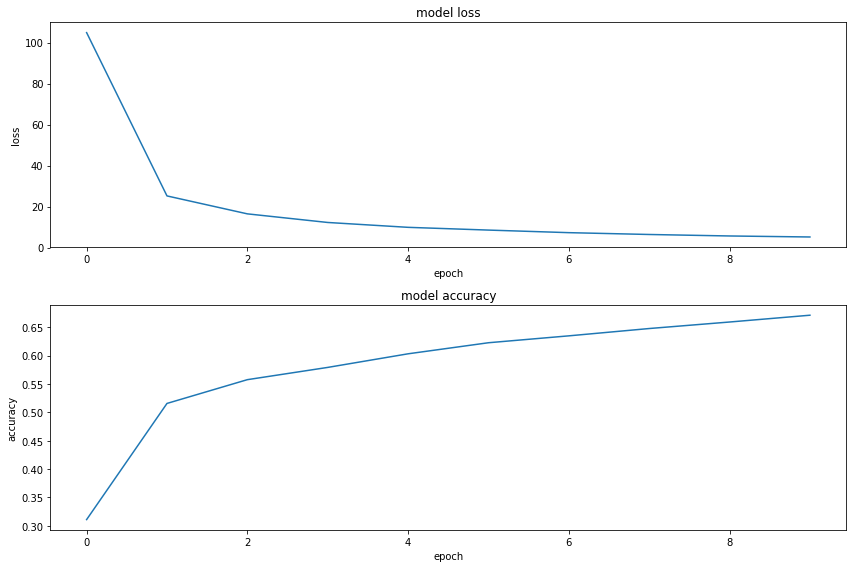

In [19]:

fig = plt.figure(figsize=(12,8))

plt.subplot(211)
plt.plot(train_loss_epoch)
plt.title("model loss")
plt.xlabel("epoch")
plt.ylabel("loss")

plt.subplot(212)
plt.plot(train_acc_epoch)
plt.title("model accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.tight_layout()
plt.show()

# 4. batch predict

In [20]:
def predict( x , batch_size=batch_size):
    
    predicted_class = np.zeros(len(x), dtype=np.int)


    for i in range(0 , len(x) , batch_size):
        j = i + batch_size
        batch_xs = x[i:min(len(x),j)]
        predicted_class[i:min(len(x),j)] = sess.run(predict_class,feed_dict={
            x_input:batch_xs
        }) 

    return predicted_class
# predict(val_x)
    

# 5. compute accuracy

In [21]:
def compute_loss_acc(x , y , batch_size=batch_size):
    
    losses_val = []
    accuracy_val = []
    
    for i in range(0,len(x),batch_size):
        x_val_batch = x[i:min(i+batch_size , len(x))]
        y_val_batch = y[i:min(i+batch_size , len(y))]
        
        val_loss,val_acc = sess.run([avg_loss,acc] , feed_dict={
            x_input: x_val_batch,
            y_out: y_val_batch
        })
        
        losses_val.append(val_loss)
        accuracy_val.append(val_acc)
    return (np.mean(losses_val) , np.mean(accuracy_val))
        
    
    
    
# compute_loss_acc(val_x,val_y)

# 6. call backs

In [22]:

save_dir = './checkpoint/'
os.makedirs(save_dir,exist_ok=True)
save_path = save_dir + 'checkpoint.ckpt'

saver = tf.train.Saver()


## checkpoint

In [23]:
global_accuracy = 0
global_non_progress = 0

In [247]:
def test_and_save(epoch):
    global global_accuracy
    val_loss , val_acc = compute_loss_acc(val_x,val_y)
    print(f'\nepoch {epoch+1}:  loss:{val_loss:.3f} \taccuracy:{val_acc:.3f}%')
    
    if global_accuracy < val_acc:
        
        saver.save(sess , save_path=save_path , global_step=epoch)
        
        print(f" This epoch is receive better accuracy: {val_acc:.2f}% > {global_accuracy:.2f}%",
             f"save session...")
        global_accuracy = val_acc
    
    
    return val_loss , val_acc
# test_and_save(1)

## early stop

In [248]:
def early_stop(val_acc , steps=50):
    global global_accuracy
    global global_non_progress
    
    if global_accuracy > val_acc:
        global_non_progress+=1
    else:
        global_non_progress=0
    
    if global_non_progress>steps:
        print(f"Didn't receive better accuracy after {global_accuracy:.2f} epochs. stop training...")
        return True
    
    return False
    
    
    

## weight decay

In [249]:

with tf.name_scope("lr") as scope:
    learning_rate_decay = tf.placeholder(dtype=tf.float32 , shape = [] ,name="learning_rate")
    
def weight_decay(epoch):
    learning_rate = 1e-3
    if epoch >400:
        learning_rate *= 1e-3
        
    elif epoch >200:
        learning_rate *= 1e-2
        
    elif epoch >100:
        learning_rate *= 1e-1
        
    return learning_rate
    
    
    

## exponential decay

$$ decayed\_learning\_rate = learning\_rate *
                        decay\_rate ^{ (global\_step \; / \; decay\_steps)} $$

由 tensorflow 控制的 lr
https://www.tensorflow.org/api_docs/python/tf/train/exponential_decay

In [250]:
learning_rate_decay = tf.train.exponential_decay(1e-2, epochs, 100, 0.96, staircase=True)
with tf.name_scope('train_with_ed'):
    train_step_with_ed = tf.train.AdamOptimizer(learning_rate=learning_rate_decay).minimize(avg_loss)
    
    

# 7. train again

In [251]:
from sklearn.utils import shuffle

sess = tf.Session()
sess.run(tf.global_variables_initializer())

train_loss_epoch,train_acc_epoch = [] , []
test_loss_epoch , test_acc_epoch = [] , []

use_step_decay = True
use_exponential = True

epochs = 20


for i in tqdm_notebook(range(epochs)):
    start_time = time.time()
    print(f"\nepoch: {i+1}/{epochs} \n")
    
    train_batch_loss = []
    train_batch_acc = []

    
    batch_num = int(np.ceil(len(train_x)/batch_size))
    split_step = batch_num // every_print
    train_x , train_y = shuffle(train_x , train_y)
    
    for j in range(batch_num):
#         batch_start = time.time()
        
        x_batch = train_x[j*batch_size : min((j+1)*batch_size , len(train_x)) ]
        y_batch = train_y[j*batch_size : min((j+1)*batch_size , len(train_y)) ]
        
        if use_step_decay:
            _ , train_loss , train_acc =sess.run([train_step , avg_loss , acc],
                                                feed_dict={
                                                    x_input : x_batch, 
                                                    y_out : y_batch,
                                                    learning_rate_decay:weight_decay(i)
                                                })
        elif use_exponential:
            _ , train_loss , train_acc =sess.run([train_step_with_ed , avg_loss , acc],
                                                feed_dict={
                                                    x_input : x_batch, 
                                                    y_out : y_batch
                                                    
                                                })
        else:
            _ , train_loss , train_acc =sess.run([train_step , avg_loss , acc],
                                                feed_dict={
                                                    x_input : x_batch, 
                                                    y_out : y_batch
                                                    
                                                })
        
        
        
        train_batch_loss.append(train_loss)
        train_batch_acc.append(train_acc)
        
        
        if j%split_step == 0: 
            print( f"step{(j//split_step)+1:>3}: acc: {train_acc:8.3f}% \tloss: {train_loss:8.3f}" )
    val_loss , val_acc = test_and_save(i)
    
    test_loss_epoch.append(val_loss)
    test_acc_epoch.append(val_acc)
    
    duration = time.time() - start_time
    print( f"time per epoch: {duration:4.4f} sec \n") 
    train_loss_epoch.append(np.mean(train_batch_loss))
    train_acc_epoch.append(np.mean(train_batch_acc))
    
    if early_stop(val_acc):
        break
    



epoch: 1/20 

step  1: acc:    0.125% 	loss:  212.984
step  2: acc:    0.156% 	loss:  134.300
step  3: acc:    0.469% 	loss:   68.483
step  4: acc:    0.281% 	loss:   58.718
step  5: acc:    0.531% 	loss:   33.458

epoch 1:  loss:34.227 	accuracy:0.452%
 This epoch is receive better accuracy: 0.45% > 0.00% save session...
time per epoch: 0.3801 sec 


epoch: 2/20 

step  1: acc:    0.438% 	loss:   34.532
step  2: acc:    0.375% 	loss:   28.080
step  3: acc:    0.562% 	loss:   20.597
step  4: acc:    0.500% 	loss:   24.508
step  5: acc:    0.406% 	loss:   21.969

epoch 2:  loss:18.195 	accuracy:0.518%
 This epoch is receive better accuracy: 0.52% > 0.45% save session...
time per epoch: 0.3536 sec 


epoch: 3/20 

step  1: acc:    0.469% 	loss:   28.730
step  2: acc:    0.500% 	loss:   19.632
step  3: acc:    0.531% 	loss:   15.019
step  4: acc:    0.562% 	loss:   11.388
step  5: acc:    0.688% 	loss:    5.491

epoch 3:  loss:13.430 	accuracy:0.542%
 This epoch is receive better accurac

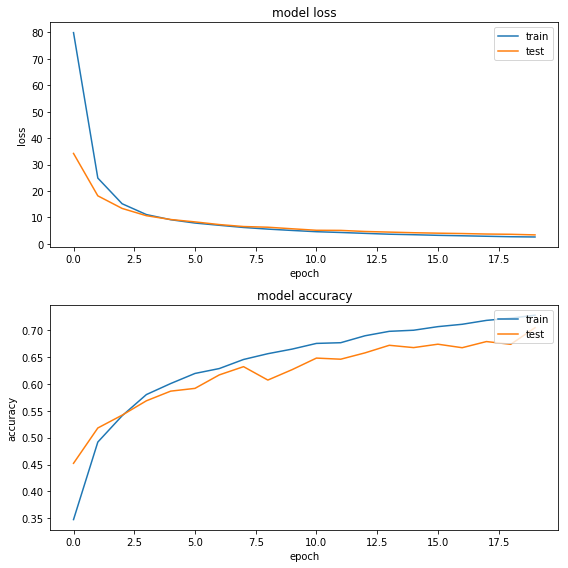

In [252]:
fig = plt.figure(figsize=(8,8))

plt.subplot(211)
plt.plot(train_loss_epoch)
plt.plot(test_loss_epoch)
plt.legend(['train','test'],loc='upper right')
plt.title("model loss")
plt.xlabel("epoch")
plt.ylabel("loss")

plt.subplot(212)
plt.plot(train_acc_epoch)
plt.plot(test_acc_epoch)
plt.legend(['train','test'],loc='upper right')
plt.title("model accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.tight_layout()
plt.show()